# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

# Calibrating and synthetic simulations of multi-site Rainfall with the STNSRPM.


In this script we calibrate the STNSRPM (Space-Time Neyman Scott Rectangular Pulse Model) using several rainfall series from the Asón river basin in northern Spain. The calibration parameters are used to simulate several decades of multi-site synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other things.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

<font color='red'>Please, be advised that some of the processes may take up to 20 minutes in a modern computer.</font>

### Load packages

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp

In [17]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.utils import compare_statistics, exceedence_probability, disaggregate_rainfall
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min
from NEOPRENE.STNSRP.Simulation import Simulation

In [18]:
import warnings
warnings.filterwarnings('ignore')

## Example 1. Calibration and validation of daily data

### Loading daily rainfall for Asón river basin

<font color='red'>__To calculate the cross-correlation statistic all the gauges have to overlap in any time. However, it is not necesary that all the series cover the entire period.__</font>

In [19]:
Series_Ason = pd.read_csv('auxiliary-materials/Ason/Inventario_Seriestemporales.csv', index_col=0, parse_dates=True)
Series_Ason[Series_Ason.values<0]=np.nan
Input_Series=Series_Ason.copy()

### Loading attributes for the series

In [20]:
Attributes_Ason= pd.read_csv('auxiliary-materials/Ason/Inventario_Atributos.csv')
Input_Attr=pd.DataFrame()
Input_Attr['ID']=Attributes_Ason.Id
Input_Attr['X']=Attributes_Ason.Longitud.values
Input_Attr['Y']=Attributes_Ason.Latitud.values
Input_Attr['Elevation']=Attributes_Ason.Height.values

### Shorting ID series to match with Input_Attr

In [21]:
Input_Series = Input_Series[Input_Attr.ID]

### Plotting rainfall series, seasonality

Text(0, 0.5, 'mm/month')

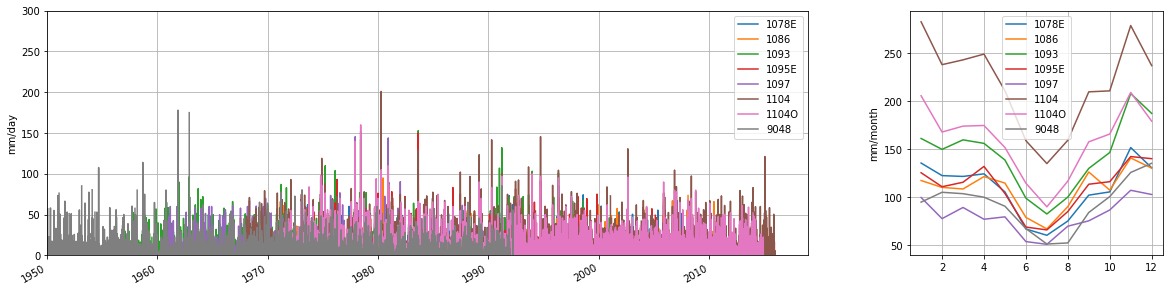

In [22]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Series.index.year[0]); t2=str(Input_Series.index.year[-1])
Input_Series.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Series.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Series>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

### Plotting gauge position

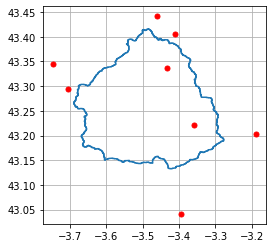

In [23]:
sf = shp.Reader("auxiliary-materials/Ason/Subbasin_WGS84.shp")

fig, ax = plt.subplots(figsize=(4, 4))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y)
ax.plot(Input_Attr.X, Input_Attr.Y, '.r',markersize=10)
ax.grid()

### Calibration

The calibration input file ([Input_Cal_Ason.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_Ason.yml)) contains the hyperparameters to calibrate the space-time model. This hyperparameters are loaded by the ```Calibration``` class within the ```NEOPRENE.STNSRP.HiperParams``` module. In this notebook, the module is loaded as ```Calhps```.

Input rainfall statistics can be directly calculated by the software from a time series or can be introduced from a file with the statistics (both options are shown in the present notebook).

A description of the hyperparamters available in the calibration file ([Input_Cal_Ason.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_Ason.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

In [24]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_Ason.yml')

The original time series statistics are computed first, as the model calibrates against those statistics. Once the statistics have been computed, the library does not need the complete time series anymore.

In [26]:
# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series, attributes = Input_Attr)

# Input statistics from file 
statistics_model_2 = Statistics(hiper_params_cal, files_folder = './statistics_Ason/')

The hyperparameters are passed to the Calibration class which return a calibrator object. This object can be used as a function, that receives the statistics that need to be reproduced by the model. The object can also save the calibrated parameters to disk for later use.

In [27]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, Input_Series, verbose=True)
os.makedirs('./ASON/CAL1/',exist_ok=True)
CAL1.save_files('./ASON/CAL1/') #save python objects



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)



Fitting the months = (1, 2, 3)

Initialization number  = 0
Initial best position  3.6646409338843298 [1.36394026e-01 1.77807711e+01 1.33834812e+03 6.46821571e-01
 2.05831629e-01]
Iteration number  = 0
Total error = 3.6646409338843298
Iteration number  = 1
Total error = 3.6646409338843298
Iteration number  = 2
Total error = 0.3187116628121555

Fitting the months = (4, 5, 6)

Initialization number  = 0
Initial best position  5.025816832785869 [5.17620762e-02 2.06404618e+01 1.08859393e+03 1.02429428e+00
 1.16163198e-01]
Iteration number  = 0
Total error = 5.025816832785869
Iteration number  = 1
Total error = 5.025816832785869
Iteration number  = 2
Total error = 2.6222106176939977
Iteration number  = 3
Total error = 2.259961681327955
Iteration number  = 4
Total error = 2.259961681327955
Iteration number  = 5
Total error = 2.2599616813279

### Simulation

The input simulation file ([Input_Sim_Ason.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_Ason.yml)) contains the hypermarametes for rainfall simulation.

A description of the hyperparamters available in the simulation file ([Input_Sim_Ason.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_Ason.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

The first thing we do is to load the hyperparameters

In [28]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_Ason.yml')

And those hyperparameters are then used to configure the Simulation class, which return a Simulation object that is used in a very similar way to the Calibration object.

In [ ]:
SIM              = Simulation(hiper_params_sim) 

# Input parameters from the model
SIM1             = SIM(params_cal = CAL1, Input_Series = Input_Series, Input_Attr = Input_Attr)

# Input parameters from a dataframe
#SIM1             = SIM(params_cal =['./ASON/CAL1/Calibrated_parameters.csv',
#                                    './ASON/CAL1/xi_months.csv'], 
#                       Input_Series = Input_Series, Input_Attr = Input_Attr)

os.makedirs('./ASON/SIM1/',exist_ok=True)
SIM1.save_files('./ASON/SIM1/')



################################################################################
Synthetic simulation


Simulation corners: 
 xp:[-5.155736963987964, -1.7800630360120353, -1.7800630360120353, -5.155736963987964]
 yp:[41.63176303601203, 41.63176303601203, 44.851036963987966, 44.851036963987966]
Simulation area (km²):100422.79736752002
Cells per storm per km²: 
[0.00060376 0.00060376 0.00060376 0.00034388 0.00034388 0.00034388
 0.00011781 0.00011781 0.00011781 0.00068187 0.00068187 0.00068187]
Cells per storm in my simulation area: 
[60.63137875 60.63137875 60.63137875 34.53334415 34.53334415 34.53334415
 11.83057196 11.83057196 11.83057196 68.47577981 68.47577981 68.47577981]
Number of storms 1294 for the months (1, 2, 3)
Number of rain cells per storm 61.794435857805254


100%|██████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:54<00:00, 23.55it/s]


Number of storms 1335 for the months (4, 5, 6)
Number of rain cells per storm 61.3003745318352


100%|██████████████████████████████████████████████████████████████████████████████| 1335/1335 [00:52<00:00, 25.42it/s]


Number of storms 1343 for the months (7, 8, 9)
Number of rain cells per storm 61.790766939687266


100%|██████████████████████████████████████████████████████████████████████████████| 1343/1343 [00:53<00:00, 25.19it/s]


Number of storms 1522 for the months (10, 11, 12)
Number of rain cells per storm 35.69842312746386


100%|██████████████████████████████████████████████████████████████████████████████| 1522/1522 [00:34<00:00, 44.67it/s]


<font color='red'>__Note that the STNSRPM reproduces the mean statistics of the basin computed from all the series (Input_series). Only the statistic rainfall mean is adjusted independetly per every single gauge.__</font>

### Verification

We verificate first that the rainfall mean is properly reproduced in every single station.

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(Input_Series.mean(axis=0), SIM1.Daily_Simulation.mean(axis=0), '.r')
ax.grid()
ax.set_xlabel('Daily rainfall mean (observed)')
ax.set_ylabel('Daily rainfall mean (simulated)')

The curve of exceedence probabilities is shown to evaluate the quality of the fit of the simulations and the observations

In [ ]:
# Comparing exceedence Probability betwen Observed and Simulated series
exceedence_probability(Input_Series.max(axis=1), SIM1.Daily_Simulation.max(axis=1), SIM1.temporal_resolution)

We verificate that the cross-correlation is properly reproduced (the figure show the cross-correlation for every temporal aggregation and period of the year).

In [ ]:
for cross_sim in SIM1.crosscorr_Simulated.keys():
    for season in SIM1.crosscorr_Simulated[cross_sim].keys():
        obs_cross = statistics_model_1.crosscorr_dataframe[cross_sim][season]
        sim_cross = SIM1.crosscorr_Simulated[cross_sim][season]
        plt.plot(obs_cross['dist'], obs_cross['cross_corr'], '-b')
        plt.plot(sim_cross['dist'], sim_cross['cross_corr'], '-r')
plt.xlabel('Distance (km)')
plt.ylabel('Correlation')
plt.legend(['Observed', 'Simulated'])
plt.grid()

### Validation

Another set of verification plots is generated where the value of different observed statistics (dashed line) is compared against the fitted statistics (blue squares), that is, the best values of the statistic that the optimal parameters were able to reproduce, and against the simulated statistics (red triangles), the values of the statistics that were obtained when simulating synthetic time series with the calibrated parameters.

The model correctly reproduces those parameters for which it is calibrated. Those parameters that do not participate in the calibration procedure may exhibit a more erratic behavior, thus the differences between the calibrated and simulated values of the statistics.

In [ ]:
# Comparing the values of the statistcs (observed, fitted and simulated).
compare_statistics(CAL1, SIM1)

## Example 2. Disaggregation of daily data to hourly data

Disaggregation process might take some minutes to dissagregate several decades of data. Here we select only 5 year as an example

In [ ]:
# Period selected from the input (onserved) serie
year1 = 1985; year2 = 1990
x_series = Input_Series[(Input_Series.index.year >= year1) & (Input_Series.index.year < year2)]

In [ ]:
# Defining hourly synthetic serie
y_series = SIM1.Hourly_Simulation.copy()

In [ ]:
# Daily-to-hourly disaggregation
hourly_disaggregation = disaggregate_rainfall(x_series, y_series)

In [ ]:
daily_disaggregation = hourly_disaggregation.resample('D').agg(pd.Series.sum, min_count=1)

## Example 3. Calibration and Simulation of hourly data